In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split

In [2]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


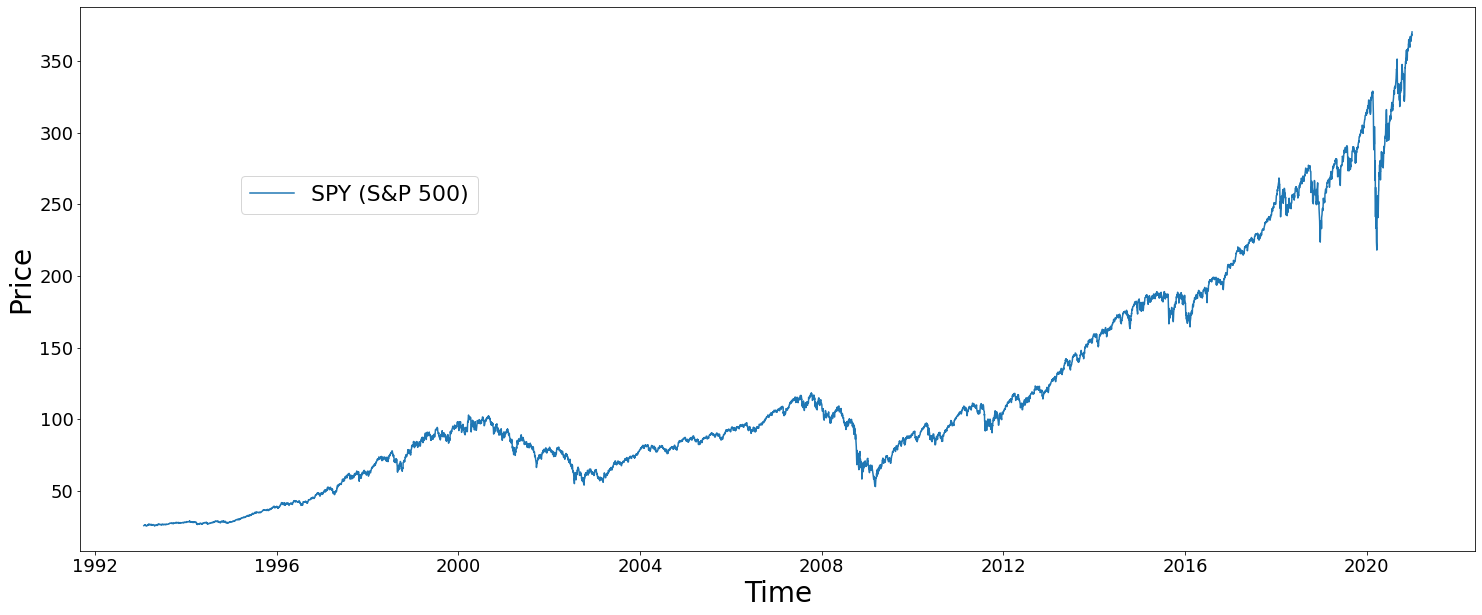

In [7]:
plt.figure(figsize=(25,10))

plt.plot(data['Close'], label='SPY (S&P 500)')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Price', fontsize=28)

plt.show()

In [3]:
df = ta.utils.dropna(data)
df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [25]:
df = df[["Open", "High", "Low", "Close", "Volume", 'trend_macd_diff', 'trend_macd', 'trend_macd_signal']]

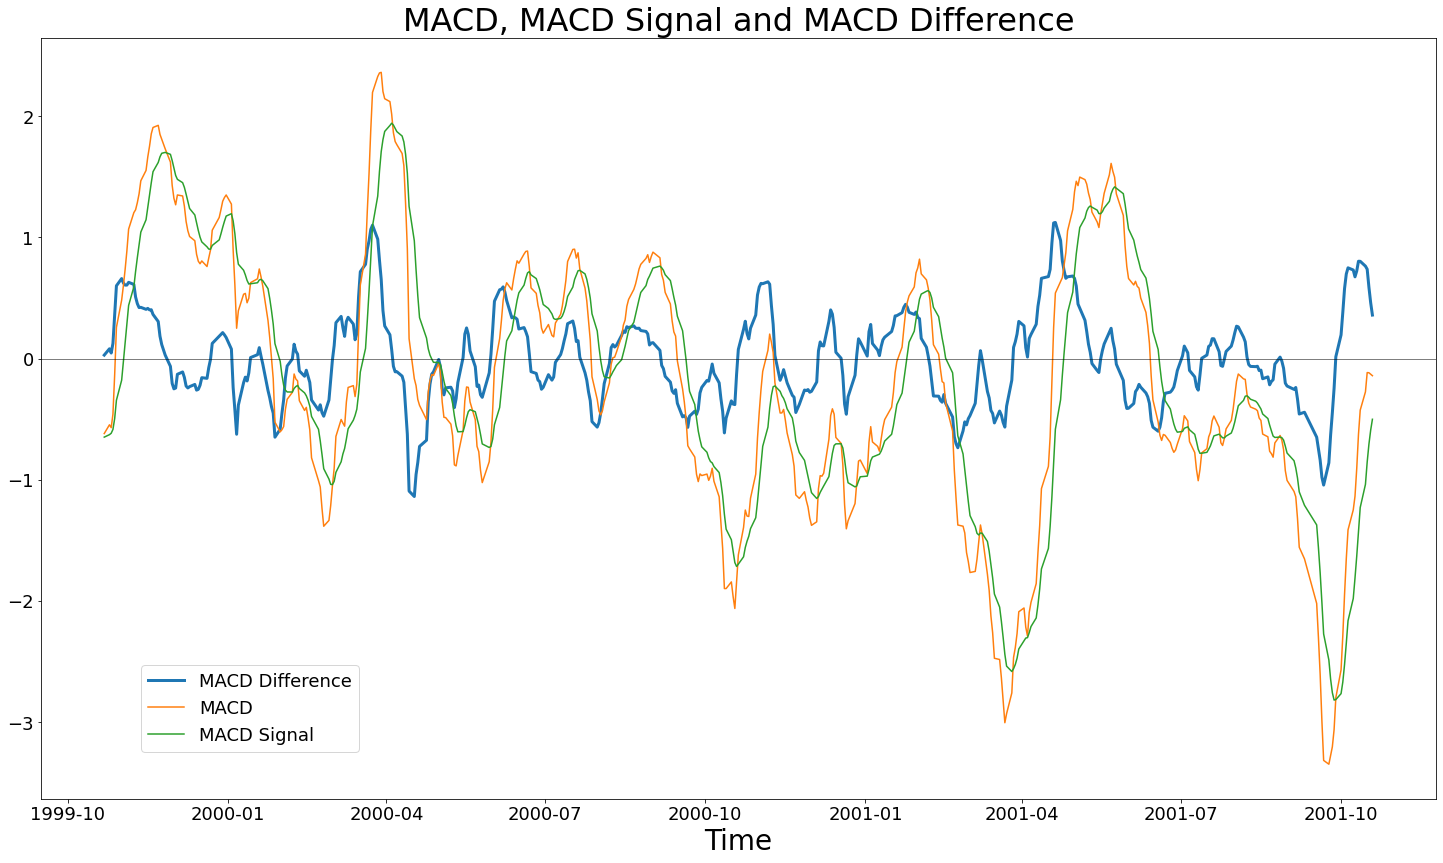

In [26]:
start, end = 1700, 2200

plt.figure(figsize=(25,14))

plt.plot(df[start:end]['trend_macd_diff'], label='MACD Difference', linewidth=3)
plt.plot(df[start:end]['trend_macd'], label='MACD')
plt.plot(df[start:end]['trend_macd_signal'], label='MACD Signal')

plt.legend(loc='lower center', bbox_to_anchor=(0.15, 0.05), fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)

plt.axhline(0, color='black', linewidth=0.5)

plt.title('MACD, MACD Signal and MACD Difference', fontsize=32)

plt.show()

In [28]:
df

,Open,High,Low,Close,Volume,trend_macd_diff,trend_macd,trend_macd_signal
Date,,,,,,,,
1993-01-29,25.735676,25.735676,25.607637,25.717384,1003200,0.000000,0.000000,0.000000
1993-02-01,25.735682,25.900303,25.735682,25.900303,480500,0.011673,0.014592,0.002918
1993-02-02,25.882018,25.973474,25.827145,25.955183,201300,0.021854,0.030236,0.008382
1993-02-03,25.991755,26.247831,25.973463,26.229540,529400,0.044522,0.064034,0.019512
1993-02-04,26.320988,26.394153,26.028329,26.339279,531500,0.063221,0.098538,0.035317
...,...,...,...,...,...,...,...,...
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900,-0.618907,3.737617,4.356525
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400,-0.403919,3.851626,4.255545
2020-12-29,370.188752,370.376914,367.237609,367.861511,53680500,-0.331663,3.840967,4.172629


In [50]:
df['trend_macd_diff_shifted'] = df['trend_macd_diff'].shift(-1)

/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_73401/3144521475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trend_macd_diff_shifted'] = df['trend_macd_diff'].shift(-1)


In [51]:
df

,Open,High,Low,Close,Volume,trend_macd_diff,trend_macd,trend_macd_signal,cross,trend_macd_diff_shifted
Date,,,,,,,,,,
1993-01-29,25.735676,25.735676,25.607637,25.717384,1003200,0.000000,0.000000,0.000000,0.011673,0.011673
1993-02-01,25.735682,25.900303,25.735682,25.900303,480500,0.011673,0.014592,0.002918,0.010180,0.021854
1993-02-02,25.882018,25.973474,25.827145,25.955183,201300,0.021854,0.030236,0.008382,0.022668,0.044522
1993-02-03,25.991755,26.247831,25.973463,26.229540,529400,0.044522,0.064034,0.019512,0.018699,0.063221
1993-02-04,26.320988,26.394153,26.028329,26.339279,531500,0.063221,0.098538,0.035317,0.006917,0.070138
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900,-0.618907,3.737617,4.356525,0.214989,-0.403919
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400,-0.403919,3.851626,4.255545,0.072256,-0.331663
2020-12-29,370.188752,370.376914,367.237609,367.861511,53680500,-0.331663,3.840967,4.172629,0.058130,-0.273533


In [72]:
def macd_cross(row):
    if row['trend_macd_diff_shifted'] > 0 and row['trend_macd_diff'] < 0:
        return 'B'
    if row['trend_macd_diff_shifted'] < 0 and row['trend_macd_diff'] > 0:
        return 'S'
    return 'H'

In [73]:
df['cross'] = df.apply(lambda row: macd_cross(row), axis=1)

/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_73401/1455380745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cross'] = df.apply(lambda row: macd_cross(row), axis=1)


In [77]:
df['signal'] = df['cross'].shift(1)
df

/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_73401/3683493429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df['cross'].shift(1)


,Open,High,Low,Close,Volume,trend_macd_diff,trend_macd,trend_macd_signal,cross,trend_macd_diff_shifted,signal
Date,,,,,,,,,,,
1993-01-29,25.735676,25.735676,25.607637,25.717384,1003200,0.000000,0.000000,0.000000,H,0.011673,NaN
1993-02-01,25.735682,25.900303,25.735682,25.900303,480500,0.011673,0.014592,0.002918,H,0.021854,H
1993-02-02,25.882018,25.973474,25.827145,25.955183,201300,0.021854,0.030236,0.008382,H,0.044522,H
1993-02-03,25.991755,26.247831,25.973463,26.229540,529400,0.044522,0.064034,0.019512,H,0.063221,H
1993-02-04,26.320988,26.394153,26.028329,26.339279,531500,0.063221,0.098538,0.035317,H,0.070138,H
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900,-0.618907,3.737617,4.356525,H,-0.403919,H
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400,-0.403919,3.851626,4.255545,H,-0.331663,H
2020-12-29,370.188752,370.376914,367.237609,367.861511,53680500,-0.331663,3.840967,4.172629,H,-0.273533,H


In [168]:
used = df[3000:][["Open", "High", "Low", "Close", "Volume", "signal"]]
used

,Open,High,Low,Close,Volume,signal
Date,,,,,,
2004-12-27,87.222407,87.337554,86.639486,86.733040,29944100,H
2004-12-28,86.819377,87.315942,86.790590,87.207993,23422900,H
2004-12-29,87.136044,87.366334,87.042485,87.337547,22650600,B
2004-12-30,87.366300,87.488640,87.107223,87.171989,21076900,S
2004-12-31,87.294354,87.553431,86.934526,86.984901,28648800,H
...,...,...,...,...,...,...
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900,H
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400,H
2020-12-29,370.188752,370.376914,367.237609,367.861511,53680500,H


In [169]:
# MACD strategy

original_cash = 100000.0
cash, shares = original_cash, 0
eval_price = 0

macd_values = []
for index, row in used.iterrows():
    sig = row['signal']
    price = row['Open']
    eval_price = row['Close']
    if sig == 'B' and cash > 0:
        to_buy = cash // price
        cash -= to_buy * price
        shares += to_buy
    elif sig == 'S' and shares > 0:
        to_sell = shares
        cash += to_sell * price
        shares -= to_sell

    v = cash + shares * eval_price
    macd_values.append(v)

value = cash + eval_price * shares
print(f"Performance: {round(100 * (value - original_cash) / original_cash, 2)}%")

macd_strategy = pd.DataFrame(index=used.index)
macd_strategy['value'] = macd_values
macd_strategy['perf'] = 100 * (macd_strategy['value'] - original_cash) / original_cash

Performance: 1338.14%


In [170]:
# Buy and Hold strategy

original_cash = 100000.0
cash, shares = original_cash, 0
eval_price = 0

bh_values = []
for index, row in used.iterrows():
    price = row['Open']
    eval_price = row['Close']
    loc = used.index.get_loc(index)
    if loc == 0 and cash > 0:
        to_buy = cash // price
        cash -= to_buy * price
        shares += to_buy
    
    v = cash + shares * eval_price
    bh_values.append(v)

value = cash + eval_price * shares
print(f"Performance: {round(100 * (value - original_cash) / original_cash, 2)}%")

bh_strategy = pd.DataFrame(index=used.index)
bh_strategy['value'] = bh_values
bh_strategy['perf'] = 100 * (bh_strategy['value'] - original_cash) / original_cash

Performance: 324.36%


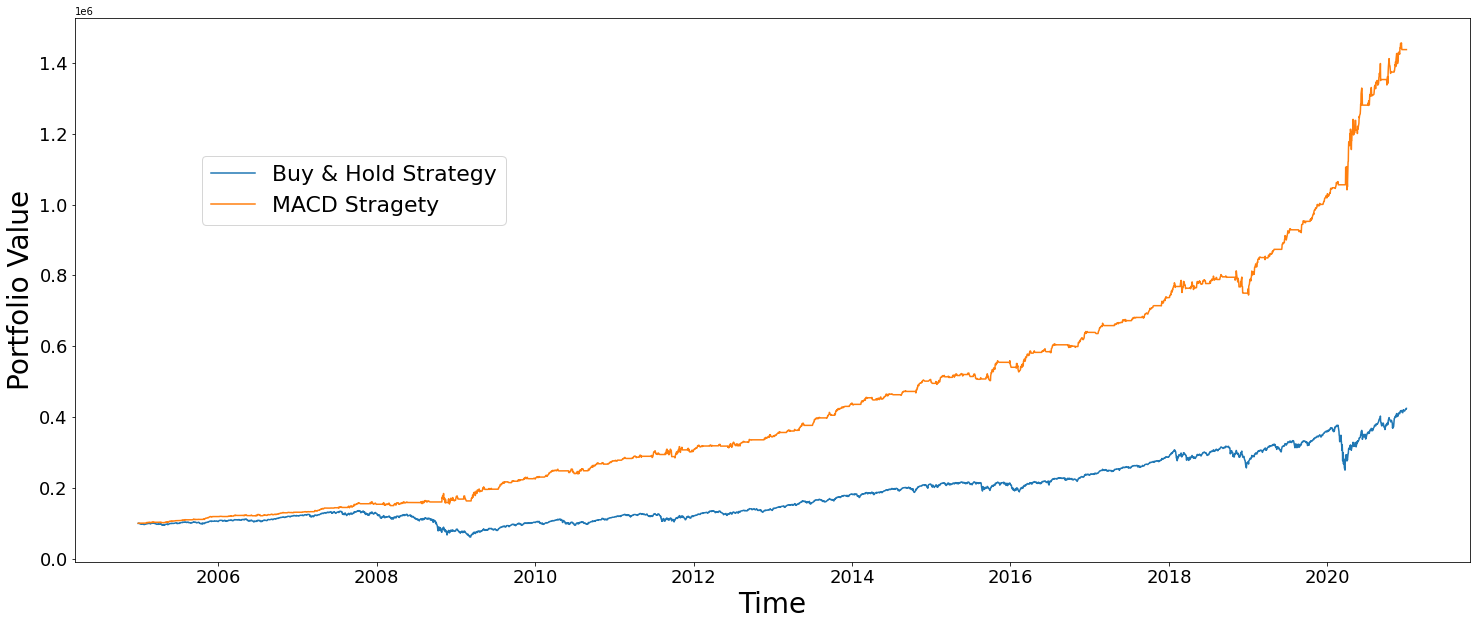

In [171]:
plt.figure(figsize=(25,10))

plt.plot(bh_strategy['value'], label='Buy & Hold Strategy')
plt.plot(macd_strategy['value'], label='MACD Stragety')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Portfolio Value', fontsize=28)

plt.show()

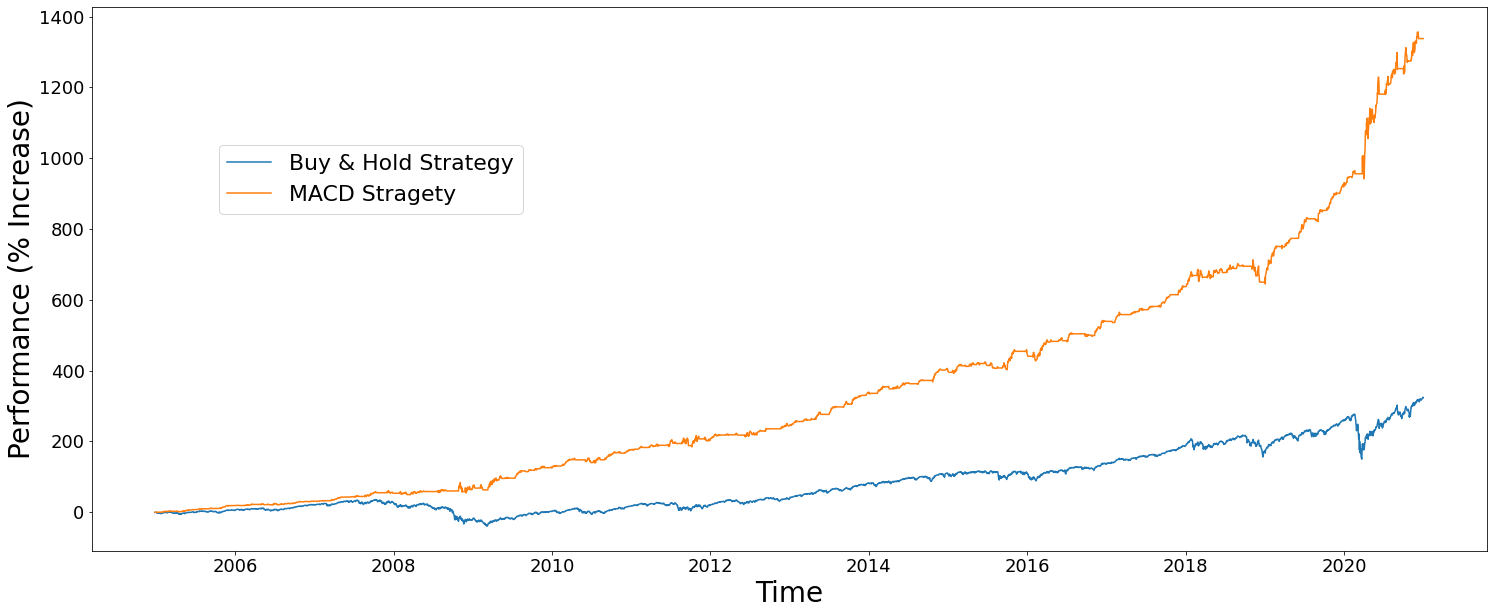

In [172]:
plt.figure(figsize=(25,10))

plt.plot(bh_strategy['perf'], label='Buy & Hold Strategy')
plt.plot(macd_strategy['perf'], label='MACD Stragety')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Performance (% Increase)', fontsize=28)

plt.show()